In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

%matplotlib widget

In [2]:
def dice_mgf(n):
    f = np.poly1d([1,0])*np.poly1d(np.ones(n))
    return f/f(1)

In [3]:
def mean_from_poly(p):
    return p.deriv()(1)

def stdev_from_poly(p):
    pd = p.deriv()*np.poly1d([1,0])
    var = pd.deriv()(1)-pd(1)**2
    return np.sqrt(var)

def dist_from_poly(p):
    return np.array(p)[::-1]
    
def cdf_from_poly(p):
    return np.cumsum(np.array(p)[::-1])

In [4]:
def standard_dice(mod =0, d4=0,d6=0,d8=0,d10=0,d12=0,d20=0):    
    return np.poly1d([1,0])**mod*dice_mgf(4)**d4*dice_mgf(6)**d6*dice_mgf(8)**d8*dice_mgf(10)**d10*dice_mgf(12)**d12*dice_mgf(20)**d20

In [5]:
def plot_dist(d):
    n = len(d)
    x = np.linspace(0,n-1,n)
    plt.figure()
    plt.plot(x,d,'.')

In [6]:
def full_from_poly(p,k=0):
    s = mean_from_poly(p)-k
    sig = stdev_from_poly(p)
    d = dist_from_poly(p)
    n = len(d)
    x = np.linspace(0,n-1,n)-k
    plt.figure()
    plt.plot(x,d,'.')
    normal = 1/sig/np.sqrt(2*np.pi)*np.exp(-1/2*(x-s)**2/sig**2)
    plt.plot(x,normal)
    plt.figure()
    plt.plot(x,cdf_from_poly(p))
    print(s,sig)

24.5 2.958039891549808


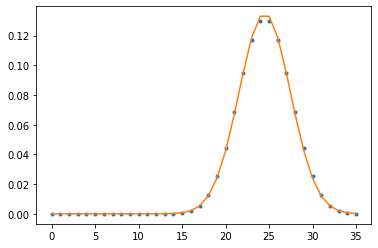

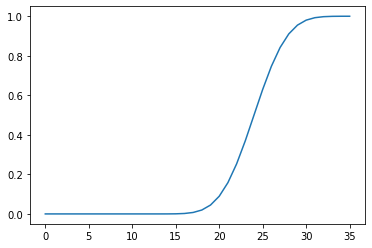

In [7]:
full_from_poly(standard_dice(mod =7,d4=7))

In [8]:
np.sqrt(0.05*0.95)

0.21794494717703367

In [9]:
full_from_poly(standard_dice(mod =0,d20=1,d8=1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

14.999999999999996 6.204836822995437


How to calculate the probability distribution for rolling exactly $S$ on $n$ $m$-sided dice if we only sum the highest $k$? 

First of all, we will use MGF (moment generating functions), or polynomials such that if the coefficient in front of $x^j$ is $a$, $P[S=j]=a$. They are helpful when calculating the probability distributions of rolling exactly $S$ on $n$ $m$-sided dice if they are all added, and they are also helpful in this more general case. 

Let us assume that if we roll all the dice and sort them, the $k$-th highest die has value $v$. There are also exactly $g$ dice with values strictly higher than $v$ and $h$ dice with values strictly lower than $v$. Clearly, all such situations, labelled by $v,g,h$ are mutually exclusive. 

The probability of such situation taking place is given by a trinomial distribution. There are three possibilities for each die: Either it rolls exactly $v$ with probability $\frac1{m}$, it rolls more than $v$ with probability $\frac{m-v}{m}$ or it rolls less than $v$ with probability $\frac{v-1}{m}$. In such specific labelled situation there are $n-g-h$ dice that roll exactly $v$, $g$ that roll higher and $h$ that roll lower, so the probability is:

$$P[v,g,h] = \left(\frac1{m} \right)^n \frac{n!}{g! h! (n-g-h)!} (v-1)^{h} (m-v)^{g}$$

If this specific situation occurs, it already contributes at least $kv$ to the overall sum, because there are $k$ dice that are at least $v$. However, it might contribute more based on what rolls on the higher $g$ dice. 

Let $Q(t,a,b)$ be a polynomial that is a MGF for rolling a sum $S$ on $a$ $b$-sided dice. We know that 

$$Q(t,a,b) =\left(\frac1{b} \right)^a \left(\frac{t^{b+1}-t}{t-1} \right)^a$$

Now, if there are exactly $g$ dice that rolled strictly higher than $v$ and we always add them all (if the situation $(v,g,h)$ occurs), then this situation contributes additional $Q(t,g,m-v)$, because this polynomial corresponds to rolling $g$ $m-v$-sided dice, and there are only $m-v$ possible rolls on each of the $g$ dice, each of them equally likely. We already added $kv$ to the sum, or $v$ for each of the $k$ dice, so we just add the excess now.

Thus this specific situation $(v,g,h)$ contributes 

$$\left(\frac1{m} \right)^n \frac{n!}{g! h! (n-g-h)!} (v-1)^{h} t^{kv} \left(\frac{t^{m-v+1}-t}{t-1} \right)^g$$

As $(m-v)^g$ cancels. 

Now we just need to sum it. Let's notice that $v$ can be anything from $1$ to $m$, then $h$ must be no larger than $n-k$ but can be exactly $n-k$, and $g$ must be smaller than $k$ and cannot be equal to $k$ as that would mean $k$-th die rolled larger than $v$. Also both $h$ and $g$ can be $0$.

The final polynomial is:

$$M(t) = \sum_{v=1}^{m-1} \sum_{h=0}^{n-k} \sum_{g=0}^{k-1} \left(\frac1{m} \right)^n \frac{n!}{g! h! (n-g-h)!} (v-1)^{h} t^{kv} \left(\frac{t^{m-v+1}-t}{t-1} \right)^g + \sum_{h=0}^{n-k} \left(\frac1{m} \right)^n \frac{n!}{ h! (n-h)!} (m-1)^{h} t^{km}$$

The second term corresponding to $v=m$ and $g=0$ situation which got cancelled with the $(m-v)^g$ term, but definitely can happen. 

In [8]:
def summand_poly(n,k,m,g,h,v):
    coeff = binom(n,g)*binom((n-g),h)
    poly1 = (v-1)**h * (m-v)**g * np.poly1d([1,0])**(k*v)
    if (m-v):
        poly2 = dice_mgf((m-v))**g
    else:
        poly2 = 1
    P = poly1*poly2
    return coeff*P

In [9]:
def poly_roll_n_dm_choose_k_highest(n,k,m):
    '''constructs an mgf polynomial corresponding to sums of k highest dice of n m-sided dice rolled together'''
    
    f = np.poly1d([0])
    # the k-th highest die can be anything from 1 to m:
    
    for v in range(1,m+1):
        
        # h has to be at most n-k but it can be exactly n - k
        
        for h in range(n-k+1):
            
            # g has to be less than k and it can't be k
            
            for g in range(k):
                
                f = f + summand_poly(n,k,m,g,h,v)
                #print(g,h,v,summand_poly(n,k,m,g,h,v))
    f[0]=0
    
    return f/f(1)
                

In [19]:
stdroll = poly_roll_n_dm_choose_k_highest(4,3,6)

In [26]:
stdroll[3]

0.0007716049382716049

In [11]:
#point buy weights
pbweights = {}
pbweights[18] = 19
pbweights[17] = 15
pbweights[16] = 12
pbweights[15] = 9
pbweights[13] = 5
pbweights[14] = 7
pbweights[12] = 4
pbweights[11] = 3
pbweights[10] = 2
pbweights[9] = 1
pbweights[8] = 0
pbweights[7] = -1
pbweights[6] = -2
pbweights[5] = -4
pbweights[4] = -6
pbweights[3] = -9


In [20]:
pointbuysingle = np.zeros(pbweights[18]-pbweights[3]+1)
for i in pbweights.keys():
    a = pbweights[18]-pbweights[i]
    b = float(stdroll[i])
    pointbuysingle[a] = b
pointbuysingle = np.poly1d(pointbuysingle)

31.435185185185205 10.872546288837736


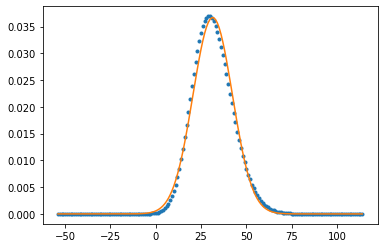

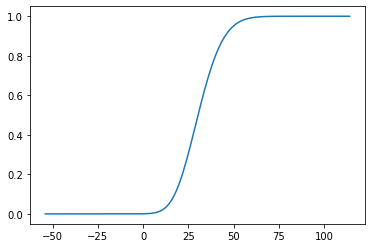

In [21]:
full_from_poly(pointbuysingle**6,k=-6*pbweights[3])

12.244598765432098 2.846844445311503


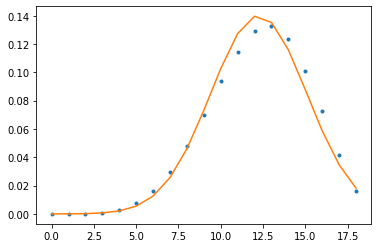

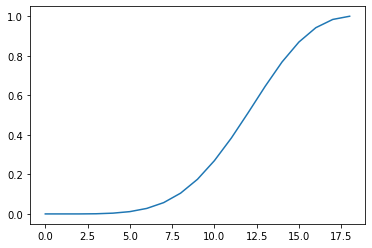

In [17]:
full_from_poly(poly_roll_n_dm_choose_k_highest(4,3,6))

361.4983333375 95.21878313506438


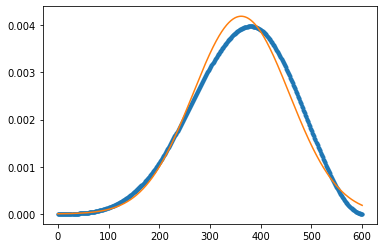

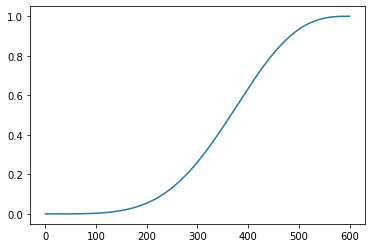

In [16]:
full_from_poly(poly_roll_n_dm_choose_k_highest(4,3,200))

Limit generating sequence

$$L(t) = \sum_{v=1}^\infty \sum_{h=0}^{n-k} \sum_{g=0}^{k-1} \frac{n!}{g! h! (n-g-h)!} (v-1)^{h} t^{kv+g} \left(\frac{1}{1-t} \right)^g$$

For example, if $n=4$, $k=3$ it is only possible that $g=0,1,2$ and $h=0,1$, so there are $6$ terms under the $\infty$ sum.

$h=0, g=0$

$$\sum_{v=1}^\infty t^{3v}$$

$h=0, g=1$

$$\sum_{v=1}^\infty 4 t^{3v+1} \left(\frac{1}{1-t}\right)$$

$h=0, g=2$

$$\sum_{v=1}^\infty 6 t^{3v+2} \left(\frac{1}{1-t}\right)^2$$

total $h=0$ 

$$\sum_{v=1}^\infty t^{3v} + 4 t^{3v+1} \left(\frac{1}{1-t}\right) +  6 t^{3v+2} \left(\frac{1}{1-t}\right)^2$$

$h=1, g=0$

$$\sum_{v=1}^\infty 4 (v-1) t^{3v}$$

$h=1, g=1$

$$\sum_{v=1}^\infty 12 (v-1) t^{3v+1} \left(\frac{1}{1-t}\right)$$

$h=1, g = 2 

$$\sum_{v=1}^\infty 12 (v-1) t^{3v+2} \left(\frac{1}{1-t}\right)^2$$

total

$$\sum_{v=1}^\infty \left(4v-3 \right) t^{3v} + \left(12v-8 \right) t^{3v+1} \left(\frac{1}{1-t}\right) +  \left(12v-6 \right) t^{3v+2} \left(\frac{1}{1-t}\right)^2$$

Or actually let's use $a = v-1$

$$\sum_{a=0}^\infty \left(4a+1 \right) t^{3a} + \left(12a +4 \right) t^{3a+1} \left(\frac{1}{1-t}\right) +  \left(12a +6 \right) t^{3a+2} \left(\frac{1}{1-t}\right)^2$$

These series differ by a factor of $t^3$ but that's fine because the sequence starts more cannonically from the zeroth term, as in, the zeroth term is the first non zero term. 

Let's expand the fractions.

$$\sum_{b=0}^\infty t^b = \left(\frac{1}{1-t}\right)$$
$$\sum_{b=0}^\infty (b+1) t^b = \left(\frac{1}{1-t}\right)^2$$

$$\sum_{a=0}^\infty \sum_{b=0}^\infty \left(4a+1 \right) t^{3a} + \left(12a +4 \right) t^{3a+b+1} +  (b+1)\left(12a +6 \right) t^{3a+b+2}$$

In [27]:
N = 1000 # number of terms required

terms = np.zeros(N,dtype=int)

for i in range(N):
    l = i % 3
    m = i//3
    
    if l==0:
        terms[i] += 4*m+1
        
        for j in range(m):
            b = 3*j+2
            a = m-j-1
            terms[i] += 12*a + 4
        
        for k in range(m):
            b = 3*k+1
            a = m-k-1
            terms[i] += (b+1)*(12*a+6)
            
    elif l==1:
        
        for j in range(m+1):
            b = 3*j
            a = m-j
            terms[i] += 12*a+4
        
        for k in range(m):
            b = 3*k+2
            a = m-k-1
            terms[i] +=(b+1)*(12*a+6)
            
    elif l==2:
        
        for j in range(m+1):
            b = 3*j+1
            a = m-j
            terms[i] += 12*a+4
            
        for k in range(m+1):
            b = 3*k
            a = m-k
            terms[i] += (b+1)*(12*a+6)

In [28]:
terms

array([        1,         4,        10,        21,        38,        62,
              95,       138,       192,       259,       340,       436,
             549,       680,       830,      1001,      1194,      1410,
            1651,      1918,      2212,      2535,      2888,      3272,
            3689,      4140,      4626,      5149,      5710,      6310,
            6951,      7634,      8360,      9131,      9948,     10812,
           11725,     12688,     13702,     14769,     15890,     17066,
           18299,     19590,     20940,     22351,     23824,     25360,
           26961,     28628,     30362,     32165,     34038,     35982,
           37999,     40090,     42256,     44499,     46820,     49220,
           51701,     54264,     56910,     59641,     62458,     65362,
           68355,     71438,     74612,     77879,     81240,     84696,
           88249,     91900,     95650,     99501,    103454,    107510,
          111671,    115938,    120312,    124795, 

In [56]:
from sympy.abc import p,q,r
from sympy import *

simplify(Sum(12*(p-q-1)+4,(q,0,p)).doit()) + simplify(Sum((12*(p-q-1)+6)*(3*q+1),(q,0,p)).doit()) +4*p+1

6*p**3 + 3*p**2 - 13*p - 13

Closed form? 

$i = 3m+l$

1. $i = 3m$

First term gives $4m+1$

Second is a sum $\sum_{j=0}^{m-1} 12(m-j-1)+4 = \sum_{j=0}^{m-1} 12m-8 -12j = m(12m-8) - 6m(m-1) = 6m^2-2m$

Third is a sum $\sum_{j=0}^{m-1} (3j+1)(12(m-j-1)+6) = \sum_{j=0}^{m-1}(3j+1)(12m-12j-6) = 6\sum_{j=0}^{m-1} 6jm -6j^2-3j+2m-2j-1  = 6m(2m-1) + 6 \sum_{j=0}^{m-1} (6m-5)j-6j^2 = 6m(2m-1) + 3 (6m-5)m(m-1) - 6m(m-1)(2m-1) = 12m^2 -6m + 18m^3-18m^2-5m^2+5m -12m^3+12m^2+6m^2-6m = 6m^3+7m^2-7m$

Total $4m+1 + 6m^2-2m +6m^3+7m^2-7m = 6m^3 +13m^2-5m+1$

<IPython.core.display.Javascript object>


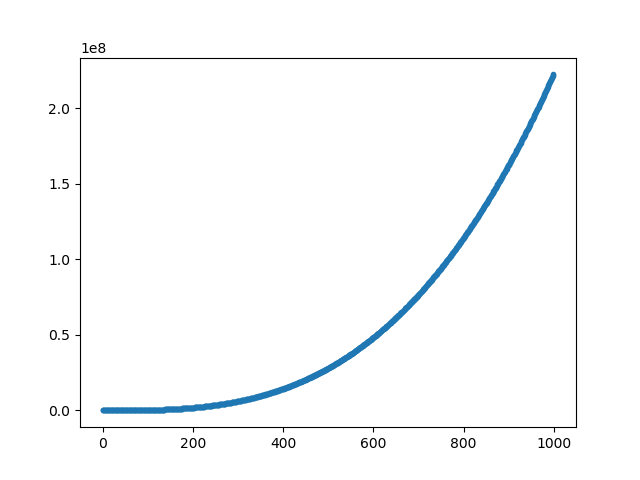

In [44]:
plt.figure()
plt.plot(terms, '.')

Limit generating sequence

$$L(t) = \sum_{v=1}^\infty \sum_{h=0}^{n-k} \sum_{g=0}^{k-1} \frac{n!}{g! h! (n-g-h)!} (v-1)^{h} t^{kv+g} \left(\frac{1}{1-t} \right)^g$$

Now easier, $n=3, k=2$. 

The only possibilities are $g=0,1$, $h=0,1$.

$g=0,h=0$

$$\sum_{v=1}^\infty t^{2v}$$

$g=1,h=0$

$$\sum_{v=1}^\infty 3 t^{2v+1} \left(\frac{1}{1-t} \right)$$

$g=0,h=1$

$$\sum_{v=1}^\infty 3 (v-1) t^{2v}$$

$g=1,h=1$

$$\sum_{v=1}^\infty 6 (v-1) t^{2v+1 } \left(\frac{1}{1-t} \right)$$

Total

$$\sum_{a=0}^\infty \sum_{b=0}^\infty (3a+1) t^{2a} + (6a+3) t^{2a+b+1}$$

We can look at the even and odd terms separately (looking at the coefficient in front of $t^j$):

Odd $j$:

$j = 2a+b+1$ and odd, so $b$ even. $a$ goes from $0$ to $\frac{j-1}2$ and we get the sum $\sum_{a=0}^{\frac{j-1}2} 6a+3$, which is just an arithmetic sequence, so it is equal to $6 \left(\frac{j-1}2 \frac{j+1}4 \right) + 3 \frac{j+1}2 = 3 \frac {j^2-1}4 +  3 \frac{j+1}2 = 3\frac{j^2-1+2j+2}4  = \frac34 \left(j+1 \right)^2$

Even $j$:

We have two contributions. The first term gives $\frac32j+1$. 

Then, for the second term, we have $j = 2a+b+1$ so $b$ is odd. $a$ goes from $0$ to $\frac{j}2-1$, so we get the sum $\sum_{a=0}^{\frac{j}2 -1} 6a+3$, which again is just an arithmetic sequence and is equal to $6 \left( \frac{j(j-2)}{8} \right) +\frac32 j = 3 \frac{j^2-2j}4 + \frac32 j$.

Together with the first term we have

$3 \frac{j^2-2j}4 + 3 j +1 = 3 \frac{j^2+2j+1}4 + \frac14 = \frac34 \left(j+1 \right)^2 + \frac14$

So if we move to $k=j+1$ we have $\frac34 k^2$ for even $k$ and $\frac14 (3k^2+1)$ for odd $k$. 

Thus this is A077043.

Limit generating sequence in general

$$L(t) = \sum_{v=1}^\infty \sum_{h=0}^{n-k} \sum_{g=0}^{k-1} \frac{n!}{g! h! (n-g-h)!} (v-1)^{h} t^{kv+g} \left(\sum_{b=0}^{\infty} t^b \right)^g$$

Storytelling to prove

$$\left(\sum_{b=0}^{\infty} t^b \right)^g = \sum_{b=0}^{\infty} {{b+g-1} \choose {g-1}} t^b$$

Thus

$$L(t) = \sum_{b=0}^{\infty} \sum_{a=0}^\infty \sum_{h=0}^{n-k} \sum_{g=0}^{k-1} \frac{n!}{g! h! (n-g-h)!} a^{h} {{b+g-1} \choose {g-1}} t^{ka+g+b} $$